<center>
<h1>Investigating the Py-ART data model for radar data</h1>
<i>Scott Collis<sup>1</sup> and 
Jonathan Helmus<sup>1</sup> 
<br>
1:Argonne National Laboratory
<br>
Slightly modified by Steve Nesbitt (U. Illinois) to work with C-SAPR data for UBA Short course.

</center>

This notebook explores the data model used for pointing radar data in the Python ARM Radar Toolkit (Py-ART). We will do this by loading a radar file from CF-Radial from ARM's C-Band system in the North Slope of Alaska Barrow site.

If you are not running this notebook in the short course VM, 
go fetch the data from <a href = 'https://engineering.arm.gov/~jhelmus/sample_xsapr_a1_files/2013_12_03_NSA/nsaxsaprrhiC1.a1/nsaxsaprrhiC1.a1.20131203.141936.nc'> HERE </a> and place it in a data directory in the same directory as this notebook. 

In [4]:
import pyart
from matplotlib import pyplot as plt
%matplotlib inline
filename = 'data/cfrad.20110523_221616.000_to_20110523_222150.1000_sgpc_v0_SUR.nc'

Read the CF-Radial file into Py-ART's data model for pointing gated data

In [5]:
radar = pyart.io.read(filename)

Lets investigate what is at the top level with a dir() command 

In [3]:
dir(radar)

['__class__',
 '__delattr__',
 '__dict__',
 '__doc__',
 '__format__',
 '__getattribute__',
 '__hash__',
 '__init__',
 '__module__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_check_sweep_in_range',
 '_dic_info',
 'add_field',
 'add_field_like',
 'altitude',
 'altitude_agl',
 'antenna_transition',
 'azimuth',
 'check_field_exists',
 'drift',
 'elevation',
 'extract_sweeps',
 'fields',
 'fixed_angle',
 'georefs_applied',
 'get_azimuth',
 'get_elevation',
 'get_end',
 'get_field',
 'get_slice',
 'get_start',
 'get_start_end',
 'heading',
 'info',
 'instrument_parameters',
 'iter_azimuth',
 'iter_elevation',
 'iter_end',
 'iter_field',
 'iter_slice',
 'iter_start',
 'iter_start_end',
 'latitude',
 'longitude',
 'metadata',
 'ngates',
 'nrays',
 'nsweeps',
 'pitch',
 'radar_calibration',
 'range',
 'ray_angle_res',
 'rays_are_indexed',
 'rays_per_sweep',
 'roll',
 'rotation',
 'scan_rate',
 'sc

Anything in the data model which contains array-like data is a dictionary with metadata and the actual data contained in the 'data' key, for example the array which contains information about the elevation angle of the sensor. 

In [4]:
radar.azimuth.keys()

[u'units', u'long_name', 'data', u'_FillValue']

In [8]:
radar.azimuth['long_name']

u'ray_azimuth_angle'

In [9]:
radar.azimuth['data']

array([   0.,    1.,    2., ...,  357.,  358.,  359.], dtype=float32)

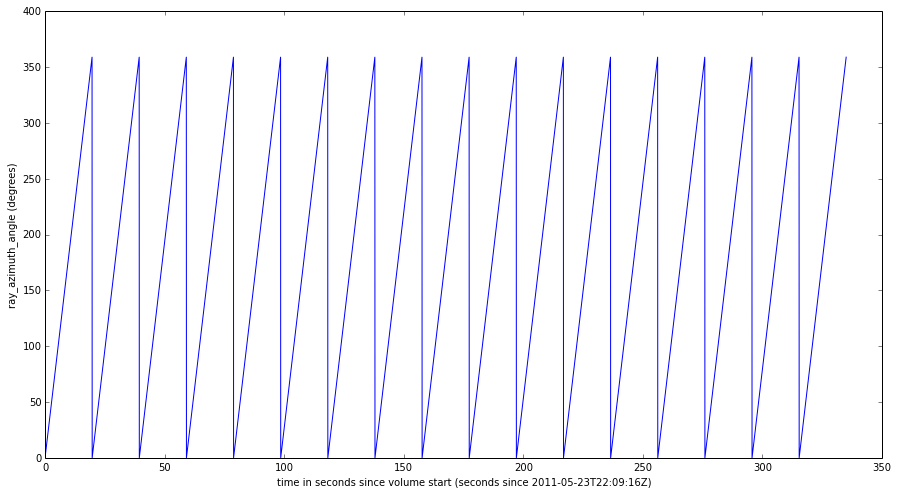

In [11]:
f = plt.figure(figsize=[15,8])
plt.plot(radar.time['data'], radar.azimuth['data'] )
plt.xlabel(radar.time['long_name'] + ' (' + radar.time['units'] + ')')
plt.ylabel(radar.azimuth['long_name'] + ' (' + radar.azimuth['units'] + ')')

So all the pointing data is contained in the base object, the azimuth and elevation of the antenna/sensor plus the range and time axes

117.878 117876.0 meters


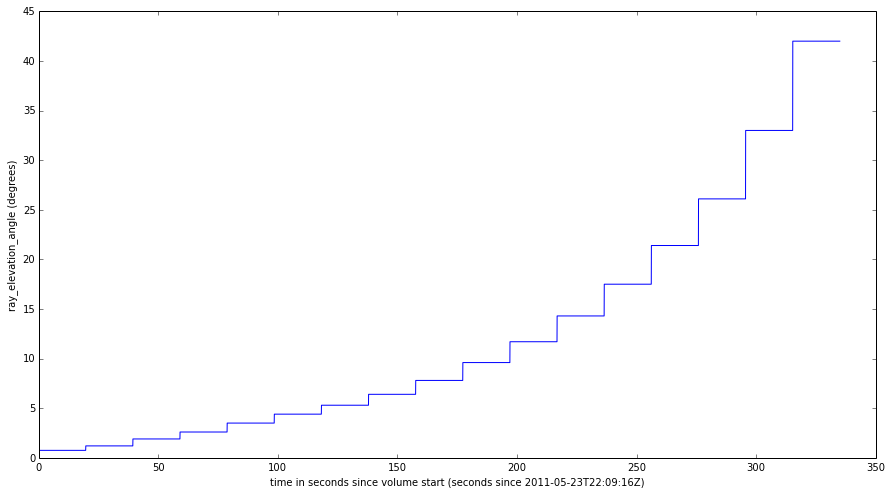

In [13]:
print radar.range['data'].min(), radar.range['data'].max(), radar.range['units']
f = plt.figure(figsize=[15,8])
plt.plot(radar.time['data'], radar.elevation['data'] )
plt.xlabel(radar.time['long_name'] + ' (' + radar.time['units'] + ')')
plt.ylabel(radar.elevation['long_name'] + ' (' + radar.elevation['units'] + ')')

there is also a swag of metadata contained within, well.. the metadata dictionary

In [14]:
for mykey in radar.metadata.keys():
    print mykey, ': ', radar.metadata[mykey]

comment :  
instrument_type :  radar
site_name :  
Sub_conventions :  CF-Radial instrument_parameters radar_parameters
references :  
volume_number :  0
scan_id :  0
title :  
source :  MDV radar volume file created by Dsr2Vol.
version :  CF-Radial-1.3
instrument_name :  sgpcsapr
ray_times_increase :  true
platform_is_mobile :  false
driver :  RadxConvert(NCAR)
institution :  
n_gates_vary :  false
primary_axis :  axis_z
created :  2015/03/27 17:27:23
scan_name :  
author :  
Conventions :  CF-1.6
platform_type :  fixed
history :  created by user sc8 on bds2-vm1 at 23-Jan-2013,23:31:07 using ./process_and_save_csapr_params.py


Now the final top level bit of information, the data model we use follows CF-Radial morphology and hence has a set of "helper" fields to format out the radar coverage pattern. That is, to seperate sweeps.

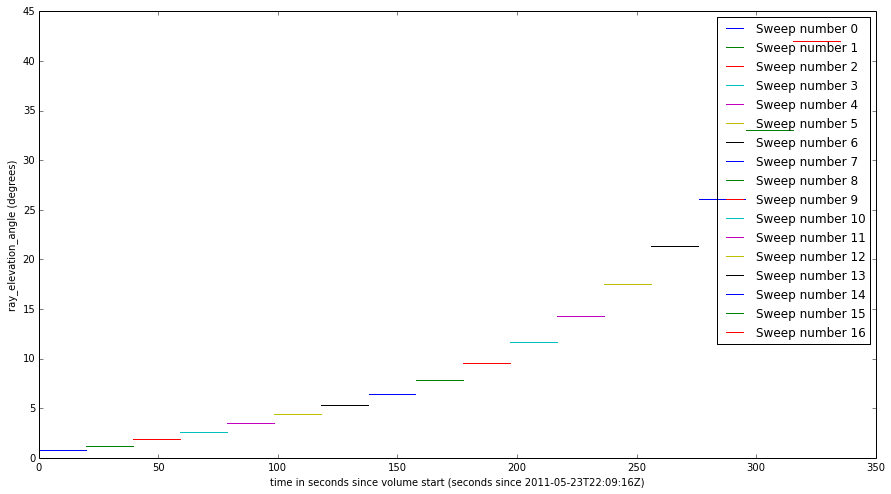

In [15]:
radar.sweep_end_ray_index['data']
f = plt.figure(figsize=[15,8])
for i in range(len(radar.sweep_end_ray_index['data'])):
    start_index = radar.sweep_start_ray_index['data'][i]
    end_index = radar.sweep_end_ray_index['data'][i]
    plt.plot(radar.time['data'][start_index:end_index], 
             radar.elevation['data'][start_index:end_index], 
             label = 'Sweep number '+ str(radar.sweep_number['data'][i]))
plt.legend()
plt.xlabel(radar.time['long_name'] + ' (' + radar.time['units'] + ')')
plt.ylabel(radar.elevation['long_name'] + ' (' + radar.elevation['units'] + ')')    

In [6]:
import numpy as np
print np.unique(radar.elevation['data'])

[  0.75         1.20000005   1.89999998   2.5999999    3.5          4.4000001
   5.30000019   6.4000001    7.80000019   9.60000038  11.69999981
  14.30000019  17.5         21.39999962  26.10000038  33.          42.        ]


Now to the actual data, or what ARM would call Primary Measurements. This is all stored in the field field of the radar object and is a dictionary of dictionaries. Best shown by example:

In [16]:
print radar.fields.keys()
print ""
for mykey in radar.fields.keys():
    print mykey,':', radar.fields[mykey]['long_name'] + ' (' + radar.fields[mykey]['units'] + ')'

[u'corrected_reflectivity_horizontal', u'reflectivity_horizontal', u'rain_rate_A', u'specific_attenuation', u'corrected_mean_doppler_velocity', u'unf_dp_phase_shift', u'mean_doppler_velocity', u'diff_phase', u'recalculated_diff_phase', u'norm_coherent_power', u'dp_phase_shift', u'doppler_spectral_width', u'diff_reflectivity', u'proc_dp_phase_shift', u'copol_coeff']

corrected_reflectivity_horizontal : equivalent_reflectivity_factor (dBZ)
reflectivity_horizontal : equivalent_reflectivity_factor (dBZ)
rain_rate_A : rainfall_rate (mm/hr)
specific_attenuation : specific_attenuation (dB/km)
corrected_mean_doppler_velocity : radial_velocity_of_scatterers_away_from_instrument (m/s)
unf_dp_phase_shift : differential_phase_hv (degrees)
mean_doppler_velocity : radial_velocity_of_scatterers_away_from_instrument (m/s)
diff_phase : specific_differential_phase_hv (degrees/km)
recalculated_diff_phase : specific_differential_phase_hv (degrees/km)
norm_coherent_power : signal_quality (ratio)
dp_phase_s

As far as CF-Radial ingest and write is concerned the variable names correspond to the variable names, the non-array data to the variable attributes and the 'data' key to the array.. lets look at some data

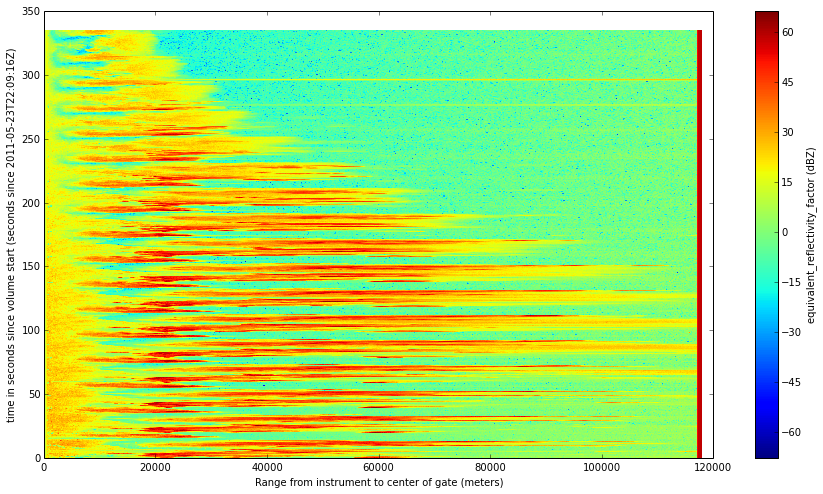

In [17]:
f = plt.figure(figsize=[15,8])
my_pc = plt.pcolormesh(radar.range['data'], radar.time['data'],
                       radar.fields['reflectivity_horizontal']['data'])
plt.xlabel(radar.range['long_name'] + ' (' + radar.range['units'] + ')')
plt.ylabel(radar.time['long_name'] + ' (' + radar.time['units'] + ')')
cb = plt.colorbar(mappable = my_pc)
cb.set_label(radar.fields['reflectivity_horizontal']['standard_name'] +\
             ' (' + radar.fields['reflectivity_horizontal']['units'] + ')')
    


And of course we can use our sweep indicators to isolate a single sweep

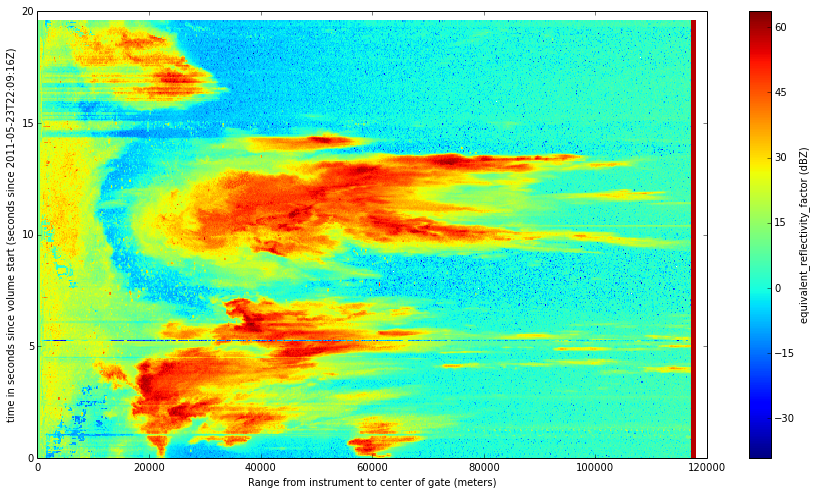

In [18]:
f = plt.figure(figsize=[15,8])
start_index = radar.sweep_start_ray_index['data'][0]
end_index = radar.sweep_end_ray_index['data'][0]
my_pc = plt.pcolormesh(radar.range['data'], radar.time['data'][start_index:end_index],
                       radar.fields['reflectivity_horizontal']['data'][start_index:end_index, :])
plt.xlabel(radar.range['long_name'] + ' (' + radar.range['units'] + ')')
plt.ylabel(radar.time['long_name'] + ' (' + radar.time['units'] + ')')
cb = plt.colorbar(mappable = my_pc)
cb.set_label(radar.fields['reflectivity_horizontal']['standard_name'] +\
             ' (' + radar.fields['reflectivity_horizontal']['units'] + ')')
    


We can get a quick overview of what is contained in the radar object using the **info** method.

In [19]:
radar.info('compact')   # see what happens with 'standard' or 'full'

altitude: <ndarray of type: float64 and shape: (1,)>
altitude_agl: <ndarray of type: float64 and shape: (1,)>
antenna_transition: <ndarray of type: int8 and shape: (6120,)>
azimuth: <ndarray of type: float32 and shape: (6120,)>
elevation: <ndarray of type: float32 and shape: (6120,)>
fields:
	corrected_reflectivity_horizontal: <ndarray of type: float32 and shape: (6120, 983)>
	reflectivity_horizontal: <ndarray of type: float32 and shape: (6120, 983)>
	rain_rate_A: <ndarray of type: float32 and shape: (6120, 983)>
	specific_attenuation: <ndarray of type: float32 and shape: (6120, 983)>
	corrected_mean_doppler_velocity: <ndarray of type: float32 and shape: (6120, 983)>
	unf_dp_phase_shift: <ndarray of type: float32 and shape: (6120, 983)>
	mean_doppler_velocity: <ndarray of type: float32 and shape: (6120, 983)>
	diff_phase: <ndarray of type: float32 and shape: (6120, 983)>
	recalculated_diff_phase: <ndarray of type: float32 and shape: (6120, 983)>
	norm_coherent_power: <ndarray of type: 

This functionality is also available from the command line using the **radar_info** command.

In [20]:
!radar_info --compact data/cfrad.20110523_220916.000_to_20110523_221451.000_sgpcsapr_v0_SUR.nc

altitude: <ndarray of type: float64 and shape: (1,)>
altitude_agl: <ndarray of type: float64 and shape: (1,)>
antenna_transition: <ndarray of type: int8 and shape: (6120,)>
azimuth: <ndarray of type: float32 and shape: (6120,)>
elevation: <ndarray of type: float32 and shape: (6120,)>
fields:
	corrected_reflectivity_horizontal: <ndarray of type: float32 and shape: (6120, 983)>
	reflectivity_horizontal: <ndarray of type: float32 and shape: (6120, 983)>
	rain_rate_A: <ndarray of type: float32 and shape: (6120, 983)>
	specific_attenuation: <ndarray of type: float32 and shape: (6120, 983)>
	corrected_mean_doppler_velocity: <ndarray of type: float32 and shape: (6120, 983)>
	unf_dp_phase_shift: <ndarray of type: float32 and shape: (6120, 983)>
	mean_doppler_velocity: <ndarray of type: float32 and shape: (6120, 983)>
	diff_phase: <ndarray of type: float32 and shape: (6120, 983)>
	recalculated_diff_phase: <ndarray of type: float32 and shape: (6120, 983)>
	norm_coherent_power: <ndarray of type: 

Thus concludes the intro! Py-ART, of course, can do all this for you including pretty PPIs etc.. but this gives an introduction to the data model we use.  Questions? Comments? Science Lead: <a href = 'mailto:scollis@anl.gov'> Scott Collis</a> Development lead: <a href = 'mailto:jhelmus@anl.gov'>Jonathan Helmus</a>.